# Brain tumor classification

# 1. Data preparation #


## 1.1 require packages

In [ ]:
!pip install numpy pillow mat73

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached mat73-0.60-py3-none-any.whl (19 kB)


In [ ]:
import os
import sys
from google.colab import drive
import scipy.io as sio
import numpy as np
import pandas as pd
from PIL import Image
import torch
from torchvision.transforms import ToTensor, Resize
import cv2
import mat73
import random
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from google.colab import drive
import pickle
import torch.nn.functional as F
drive.mount('/content/drive')

Mounted at /content/drive


## 1.2 data  visualization##

### 1.2.1 for .mat data

In [ ]:
mat = pd.DataFrame(mat73.loadmat('/content/drive/MyDrive/Stat 7007/Data Set/original_mat_data/brainTumorDatapublic/'+ str(955) +'.mat'))
print(mat)

                                                        cjdata
PID                                                     108931
image        [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
label                                                      3.0
tumorBorder  [117.78081621083082, 98.62369550184027, 117.07...
tumorMask    [[False, False, False, False, False, False, Fa...


PID: patient IDl

image: image data

label: 1 for meningioma, 2 for glioma, 3 for pituitary tumor

tumorBorder: a vector storing the coordinates of discrete points on tumor border.

tumorMask: a binary image with 1s indicating tumor region

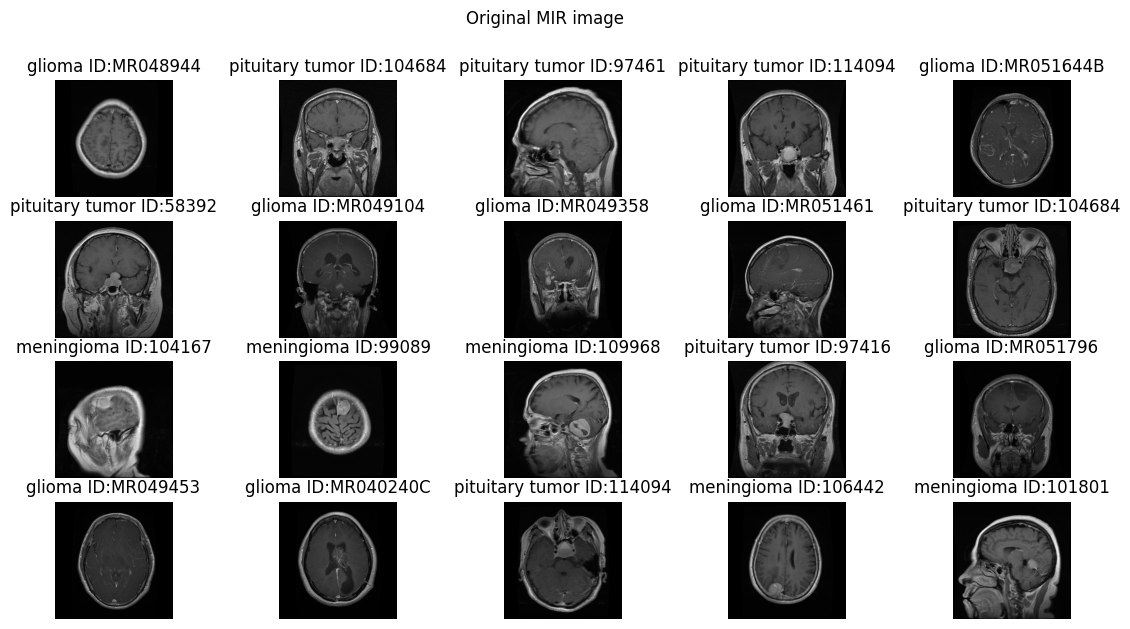

In [ ]:
random.seed(666)

label_l = ['meningioma', 'glioma', 'pituitary tumor']
fig, axs = plt.subplots(4,5,sharex=True, figsize=(14, 7))
randomlist = np.reshape(random.sample(range(1, 3064), 20),[4,5])

for i in range(4):
  for j in range(5):
    mat = pd.DataFrame(mat73.loadmat('/content/drive/MyDrive/Stat 7007/Data Set/original_mat_data/brainTumorDatapublic/'+ str(randomlist[i,j]) +'.mat'))
    axs[i,j].imshow(np.array(mat.iloc[1])[0],cmap='gray')
    axs[i,j].axis('off')
    axs[i,j].set_title(label_l[int(np.array(mat.iloc[2])[0]-1)] + ' ID:'+str(np.array(mat.iloc[0])[0]))

plt.suptitle("Original MRI image")
plt.show()

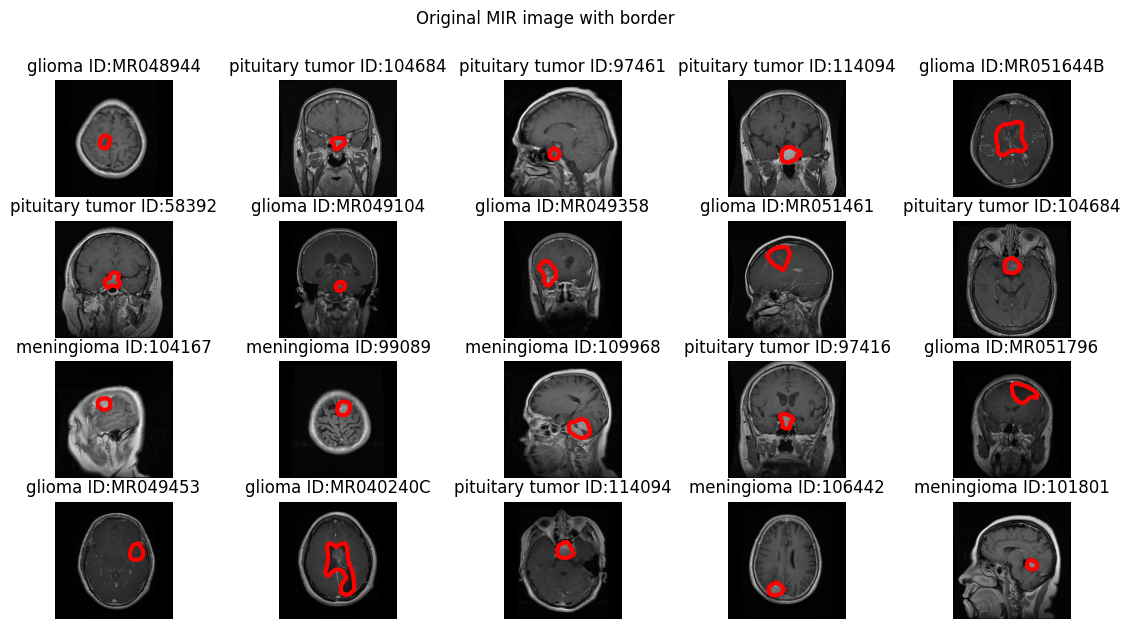

In [ ]:
random.seed(666)

label_l = ['meningioma', 'glioma', 'pituitary tumor']
fig, axs = plt.subplots(4,5,sharex=True, figsize=(14, 7))
randomlist = np.reshape(random.sample(range(1, 3064), 20),[4,5])

for i in range(4):
  for j in range(5):
    mat = pd.DataFrame(mat73.loadmat('/content/drive/MyDrive/Stat 7007/Data Set/original_mat_data/brainTumorDatapublic/'+ str(randomlist[i,j]) +'.mat'))
    axs[i,j].imshow(np.array(mat.iloc[1])[0],cmap='gray')
    tumor_border = np.array(mat.iloc[3])[0]
    tumor_border_x = tumor_border[0::2]
    tumor_border_y = tumor_border[1::2]
    axs[i,j].plot(tumor_border_x, tumor_border_y, color='red', lw=3)
    axs[i,j].axis('off')
    axs[i,j].set_title(label_l[int(np.array(mat.iloc[2])[0]-1)] + ' ID:'+str(np.array(mat.iloc[0])[0]))

plt.suptitle("Original MRI image with border")
plt.show()

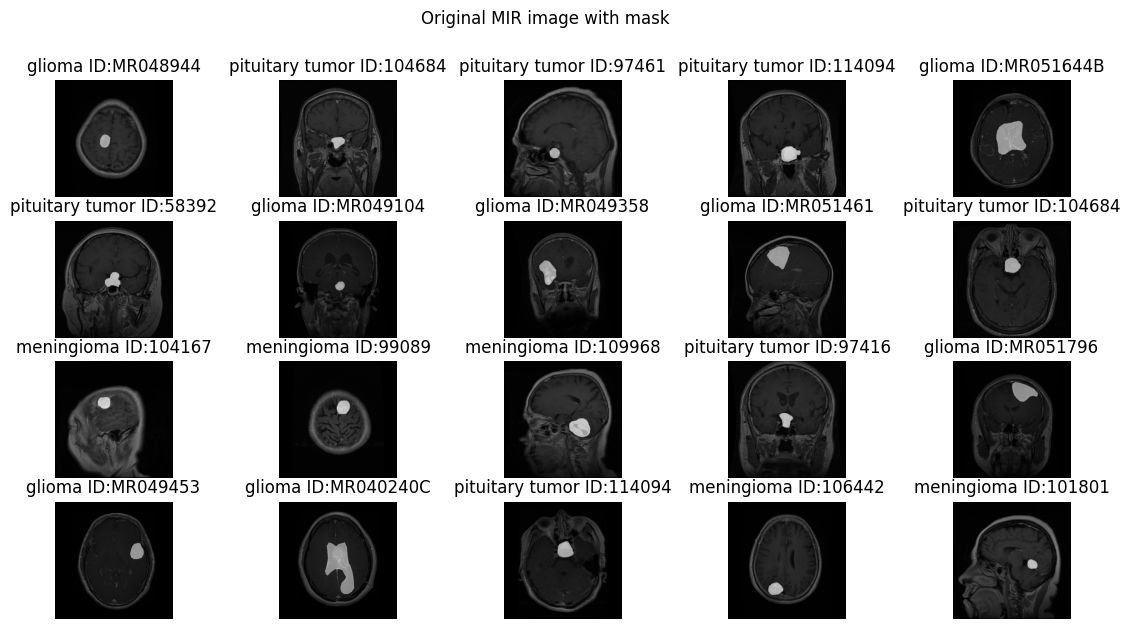

In [ ]:
random.seed(666)

label_l = ['meningioma', 'glioma', 'pituitary tumor']
fig, axs = plt.subplots(4,5,sharex=True, figsize=(14, 7))
randomlist = np.reshape(random.sample(range(1, 3064), 20),[4,5])

for i in range(4):
  for j in range(5):
    mat = pd.DataFrame(mat73.loadmat('/content/drive/MyDrive/Stat 7007/Data Set/original_mat_data/brainTumorDatapublic/'+ str(randomlist[i,j]) +'.mat'))
    axs[i,j].imshow(np.array(mat.iloc[1])[0],cmap='gray')
    axs[i,j].axis('off')
    axs[i,j].imshow(np.array(mat.iloc[4])[0],cmap='gray', alpha = 0.5)
    axs[i,j].set_title(label_l[int(np.array(mat.iloc[2])[0]-1)] + ' ID:'+str(np.array(mat.iloc[0])[0]))

plt.suptitle("Original MRI image with mask")
plt.show()

### 1.2.2 for .kaggle data

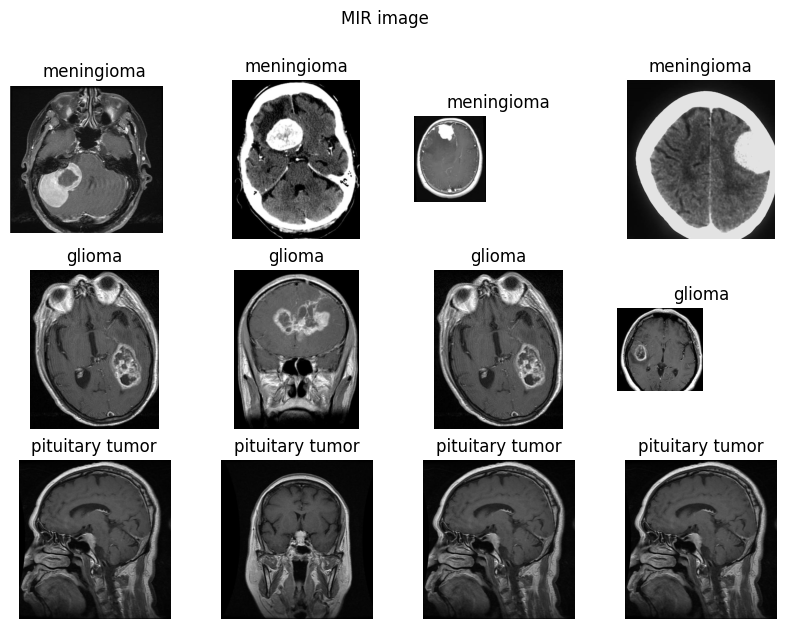

In [ ]:
fig, axs = plt.subplots(3,4,sharex=True, figsize=(10, 7))
label_l = ['meningioma', 'glioma', 'pituitary tumor']

path_name = ["meningioma_tumor","glioma_tumor","pituitary_tumor"]
for i in range(3):
  path = '/content/drive/MyDrive/Stat 7007/Data Set/original_kaggle_data/'
  path += path_name[i]
  for j in range(4):
    file_name = os.listdir(path)[j]
    image = np.array(Image.open(path+'/'+file_name).convert("L"))
    axs[i,j].imshow(image,cmap='gray')
    axs[i,j].axis('off')
    axs[i,j].set_title(label_l[i])

plt.suptitle("MRI image")
plt.show()

## 1.3 pre-processing  ##

### 1.3.1 Cropping

In [ ]:
img = cv2.imread('/content/drive/MyDrive/Stat 7007/Data Set/original_kaggle_data/meningioma_tumor/image(25).jpg')
IMG_SIZE = (256, 256)  
img = cv2.resize(img, dsize=IMG_SIZE, interpolation=cv2.INTER_CUBIC)

gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# threshold the image, then perform a series of erosions +
# dilations to remove any small regions of noise
thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

# find contours in thresholded image, then grab the largest one
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# find the extreme points
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# add contour on the image
img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

# add extreme points
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

# crop
ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

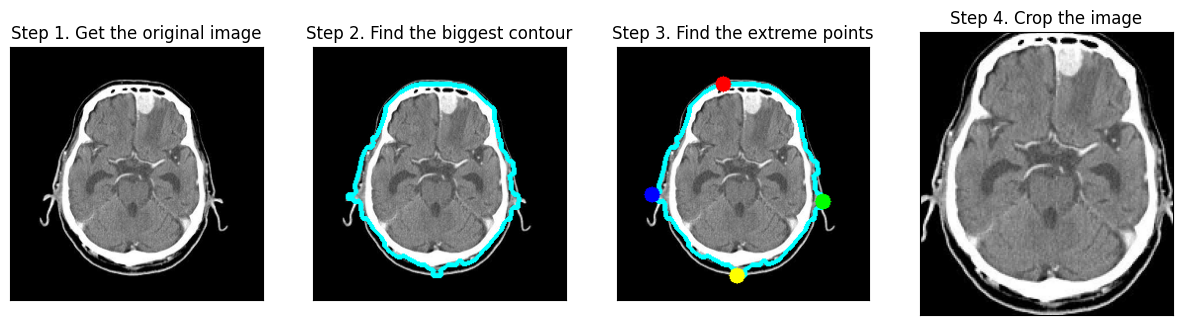

In [ ]:
plt.figure(figsize=(15,6))
plt.subplot(141)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Step 1. Get the original image')
plt.subplot(142)
plt.imshow(img_cnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 2. Find the biggest contour')
plt.subplot(143)
plt.imshow(img_pnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 3. Find the extreme points')
plt.subplot(144)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title('Step 4. Crop the image')
plt.show()

### 1.3.2 resizing 

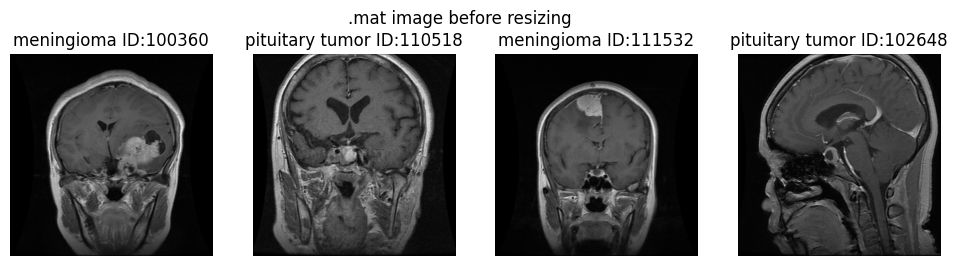

In [ ]:
random.seed(123)
label_l = ['meningioma', 'glioma', 'pituitary tumor']
fig, axs = plt.subplots(1,4,sharex=True, figsize=(12, 3))
randomlist = np.reshape(random.sample(range(1, 3064), 4),[4])

for i in range(4):
   mat = pd.DataFrame(mat73.loadmat('/content/drive/MyDrive/Stat 7007/Data Set/original_mat_data/brainTumorDatapublic/'+ str(randomlist[i]) +'.mat'))
   axs[i].imshow(np.array(mat.iloc[1])[0],cmap='gray')
   axs[i].axis('off')
   axs[i].set_title(label_l[int(np.array(mat.iloc[2])[0]-1)] + ' ID:'+str(np.array(mat.iloc[0])[0]))

plt.suptitle(".mat image before resizing")
plt.show()

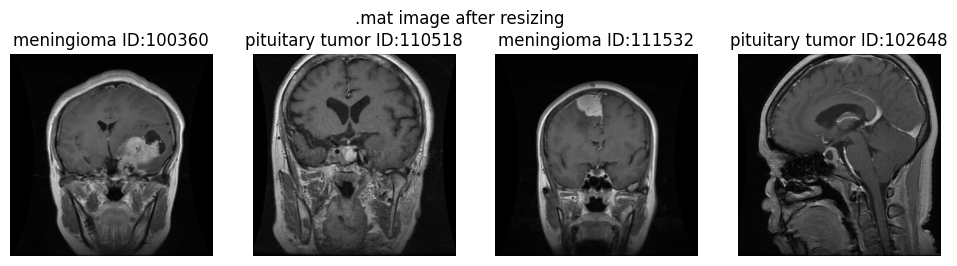

In [ ]:
random.seed(123)
label_l = ['meningioma', 'glioma', 'pituitary tumor']
fig, axs = plt.subplots(1,4,sharex=True, figsize=(12, 3))
randomlist = np.reshape(random.sample(range(1, 3064), 4),[4])

for i in range(4):
   mat = pd.DataFrame(mat73.loadmat('/content/drive/MyDrive/Stat 7007/Data Set/original_mat_data/brainTumorDatapublic/'+ str(randomlist[i]) +'.mat'))
   axs[i].imshow(cv2.resize(np.array(mat.iloc[1])[0], (256,256)),cmap='gray')
   axs[i].axis('off')
   axs[i].set_title(label_l[int(np.array(mat.iloc[2])[0]-1)] + ' ID:'+str(np.array(mat.iloc[0])[0]))

plt.suptitle(".mat image after resizing")
plt.show()

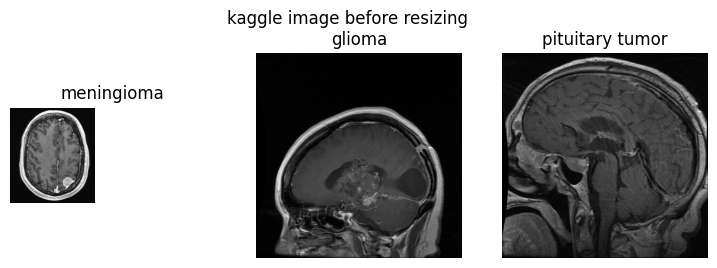

In [ ]:
random.seed(567)
fig, axs = plt.subplots(1,3,sharex=True, figsize=(9, 3))
label_l = ['meningioma', 'glioma', 'pituitary tumor']

path_name = ["meningioma_tumor","glioma_tumor","pituitary_tumor"]
for i in range(3):
  path = '/content/drive/MyDrive/Stat 7007/Data Set/original_kaggle_data/'
  path += path_name[i]
  file_name = os.listdir(path)[random.randint(1, 500)]
  image = np.array(Image.open(path+'/'+file_name).convert("L"))
  axs[i].imshow(image,cmap='gray')
  axs[i].axis('off')
  axs[i].set_title(label_l[i])

plt.suptitle("kaggle image before resizing")
plt.show()

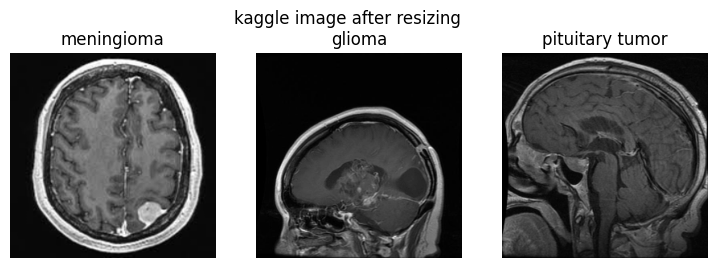

In [ ]:
random.seed(567)
fig, axs = plt.subplots(1,3,sharex=True, figsize=(9, 3))
label_l = ['meningioma', 'glioma', 'pituitary tumor']

path_name = ["meningioma_tumor","glioma_tumor","pituitary_tumor"]
for i in range(3):
  path = '/content/drive/MyDrive/Stat 7007/Data Set/original_kaggle_data/'
  path += path_name[i]
  file_name = os.listdir(path)[random.randint(1, 500)]
  image = cv2.resize(np.array(Image.open(path+'/'+file_name).convert("L")),(256,256))
  axs[i].imshow(image,cmap='gray')
  axs[i].axis('off')
  axs[i].set_title(label_l[i])

plt.suptitle("kaggle image after resizing")
plt.show()

### 1.3.3 normalizing

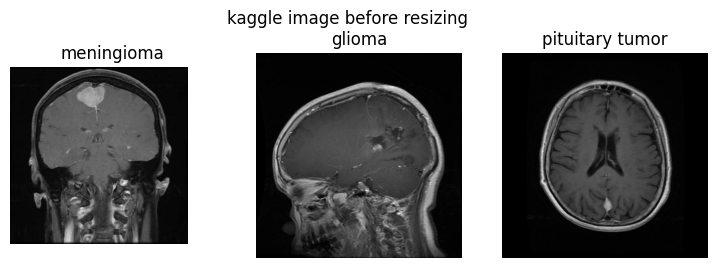

In [ ]:
random.seed(123)
fig, axs = plt.subplots(1,3,sharex=True, figsize=(9, 3))
label_l = ['meningioma', 'glioma', 'pituitary tumor']

path_name = ["meningioma_tumor","glioma_tumor","pituitary_tumor"]
for i in range(3):
  path = '/content/drive/MyDrive/Stat 7007/Data Set/original_kaggle_data/'
  path += path_name[i]
  file_name = os.listdir(path)[random.randint(1, 500)]
  image = np.array(Image.open(path+'/'+file_name).convert("L"))
  axs[i].imshow(image,cmap='gray')
  axs[i].axis('off')
  axs[i].set_title(label_l[i])

plt.suptitle("kaggle image before normalizing")
plt.show()

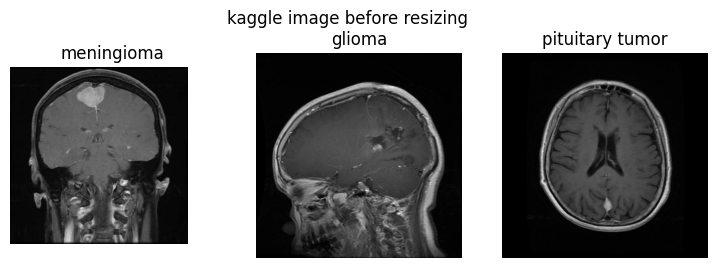

In [ ]:
random.seed(123)
fig, axs = plt.subplots(1,3,sharex=True, figsize=(9, 3))
label_l = ['meningioma', 'glioma', 'pituitary tumor']

path_name = ["meningioma_tumor","glioma_tumor","pituitary_tumor"]
for i in range(3):
  path = '/content/drive/MyDrive/Stat 7007/Data Set/original_kaggle_data/'
  path += path_name[i]
  file_name = os.listdir(path)[random.randint(1, 500)]
  image = np.array(Image.open(path+'/'+file_name).convert("L"))
  axs[i].imshow(image/255*11073,cmap='gray')
  axs[i].axis('off')
  axs[i].set_title(label_l[i])

plt.suptitle("kaggle image after normalizing")
plt.show()

### 1.3.4 Testing for different preprocess technique

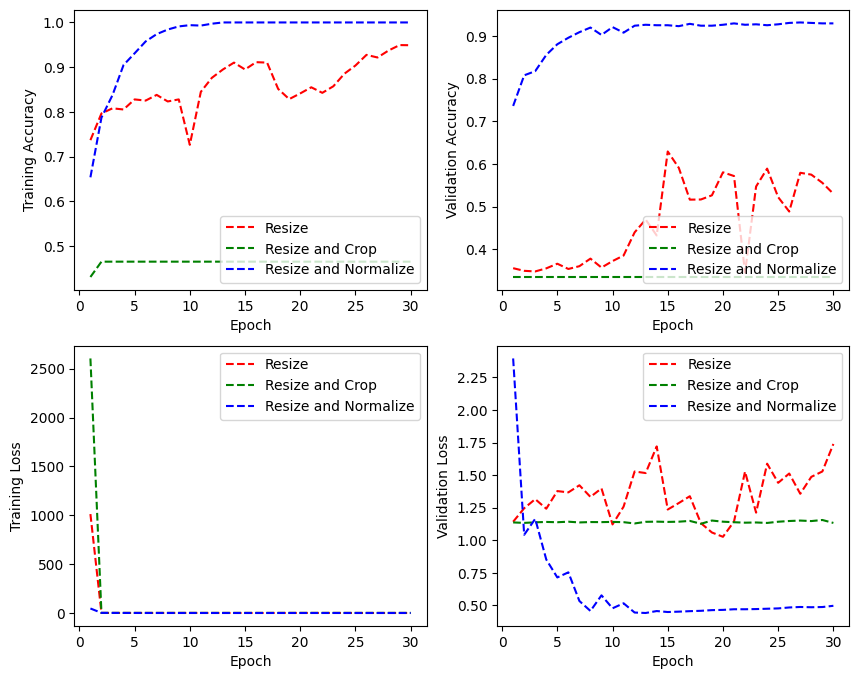

In [ ]:
import pickle
with open('/content/drive/MyDrive/Stat 7007/Loss/resize_only_data_on_SimpleCNN_loss.pkl', 'rb') as f:
  loss_info1 = pickle.load(f)
loss_info1['color'] = "red"

with open('/content/drive/MyDrive/Stat 7007/Loss/resize_and_crop_data_on_SimpleCNN_loss.pkl', 'rb') as f:
  loss_info2 = pickle.load(f)
loss_info2['color'] = "green"

with open('/content/drive/MyDrive/Stat 7007/Loss/resize_and_normalize_data_on_SimpleCNN_loss.pkl', 'rb') as f:
  loss_info3 = pickle.load(f)
loss_info3['color'] = "blue"

model_data = {'Resize': loss_info1,
              'Resize and Crop':loss_info2,
              'Resize and Normalize':loss_info3}
model_compare(model_data)

### 1.3.5 using resizing and normalizing as the final model for modeling

In [ ]:
#list_mask = []
#list_images = []
#list_label = []
#for i in range(1,3065):
#  sys.stdout.write('\r'+'processing: '+ str(i) +'.mat||'+str(i)+'/3064')
#  mat = pd.DataFrame(mat73.loadmat('/content/drive/MyDrive/Stat 7007/Data Set/original_mat_data/brainTumorDatapublic/'+ str(i) +'.mat'))
#  list_images.append(torch.from_numpy(cv2.resize(np.array(mat.iloc[1][0]), (256,256))).to(torch.float32))
#  list_label.append(torch.tensor(mat.iloc[2][0]).to(torch.float64)-1)
#  list_mask.append(torch.from_numpy(cv2.resize(np.array(mat.iloc[4][0]).astype(float), (256,256))).to(torch.float32))

#tensor_image = torch.stack(list_images)
#tensor_label = torch.stack(list_label)
#tensor_mask = torch.stack(list_mask)

#torch.save(tensor_image, '/content/drive/MyDrive/Stat 7007/Data Set/all_data_tensor/mat2tensor_float32_image.pt')
#torch.save(tensor_label, '/content/drive/MyDrive/Stat 7007/Data Set/all_data_tensor/mat2tensor_float64_label.pt')
#torch.save(tensor_mask, '/content/drive/MyDrive/Stat 7007/Data Set/all_data_tensor/mat2tensor_float32_mask.pt')
#print("done")

In [ ]:
#list_images = []
#list_label = []

#path_name = ["meningioma_tumor","glioma_tumor","pituitary_tumor"]
#for i in range(3):
#  path = '/content/drive/MyDrive/Stat 7007/Data Set/original_kaggle_data/'
#  path += path_name[i]
#  for j in os.listdir(path):
#    sys.stdout.write('\r'+'processing: '+ path+'/'+j)
#    image = np.array(Image.open(path+'/'+j).convert("L"))
#    list_images.append(torch.from_numpy(cv2.resize(image/255*11073, (256,256))).to(torch.float32))
#    list_label.append(torch.tensor(i).to(torch.float64))

#tensor_image = torch.stack(list_images)
#tensor_label = torch.stack(list_label)

#torch.save(tensor_image, '/content/drive/MyDrive/Stat 7007/Data Set/all_data_tensor/jpg2tensor_float32_image.pt')
#torch.save(tensor_label, '/content/drive/MyDrive/Stat 7007/Data Set/all_data_tensor/jpg2tensor_float64_label.pt')
#print("done")

processing: /content/drive/MyDrive/Stat 7007/Data Set/original_kaggle_data/pituitary_tumor/p (823).jpgdone


# 2.Model Design #

## 2.1 tranfer learning approach

### 2.1.1 VGG16  （used for testing only）

In [ ]:
from torchvision import datasets, models, transforms
import torch
import torch.nn as nn
import torchvision.models as models

vgg16 = models.vgg16(pretrained=True)
for param in vgg16.features.parameters():
    param.requires_grad = False

vgg16.features[0] = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)

num_features = vgg16.classifier[6].in_features
vgg16.classifier[6] = nn.Linear(num_features, 3)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 180MB/s]


### 2.1.2 Resnet18

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
class Resnet18(nn.Module):
    def __init__(self, num_classes=3):
        super(Resnet18, self).__init__()
        self.model = models.resnet18(pretrained=True)

        #  ResNet18 Change the number of gray input channels to 1
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # Freeze all layers
        for param in self.model.parameters():
            param.requires_grad = False

        # Unfreeze the first layer
        for param in self.model.conv1.parameters():
            param.requires_grad = True

        # Replace the last fully connected layer
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.model(x)

### 2.1.3 GoogLeNet

In [ ]:
import torch
from torchvision import models

# Pretrained GoogLeNet
googlenet = models.googlenet(pretrained=True, transform_input=False)

# Modify the input channel of the first convolutional layer
googlenet.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))

# Assume we are doing a three-classification task
num_ftrs = googlenet.fc.in_features
googlenet.fc = nn.Sequential(
    nn.Linear(num_ftrs, 1024),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),  # Add dropout with a probability of 0.5
    nn.Linear(1024, 3)
)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## 2.2 Lightweight learning approach

### 2.2.1 SimpleCNN

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(32 * 64 * 64, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 3)  # Assuming 3 output classes
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        
        x = x.view(x.size(0), -1)
        
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        
        return x


### 2.2.2 LeNet5

In [ ]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc1 = nn.Linear(59536, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 3)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### 2.2.3 ConvNet AdaptiveMaxPool ##

In [ ]:
class ConvNet_adapt(nn.Module):
    def __init__(self):
        super(ConvNet_adapt,self).__init__()
        self.conv1=nn.Conv2d(1,16,5,1,2)
        self.conv2=nn.Conv2d(16,32,5,1,2)   
        self.max_pool=nn.AdaptiveMaxPool2d((64,64))
        self.fc1=nn.Linear(131072,256)
        self.dropout1=nn.Dropout(p=0.5)
        self.fc2=nn.Linear(256,64)
        self.dropout2=nn.Dropout(p=0.5)
        self.classifier=nn.Linear(64,3) 

        
    def forward(self,x):
        x=F.relu(self.conv1(x))
        x=F.relu(self.conv2(x))
        x=self.max_pool(x)
        x=x.view(x.size(0),-1) 
        x=F.relu(self.fc1(x))
        x=self.dropout1(x)
        x=F.relu(self.fc2(x))
        x=self.dropout2(x)
        x=self.classifier(x)


        return x

# 3. Pipeline #

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, classification_report

class Pipeline():
  
  def __init__(self, model, criterion, optimizer, model_name, num_epochs, patience = 10):
    self.model = model
    self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    self.criterion = criterion
    self.optimizer = optimizer
    self.model_name = model_name
    self.num_epochs = num_epochs
    self.patience = patience
    self.model_path = '/content/drive/MyDrive/Stat 7007/Model/'+ self.model_name + '_best_weights.pt'
    self.loss_path = '/content/drive/MyDrive/Stat 7007/Loss/' + self.model_name + '_loss.pkl'
    self.best_model_weights = None
  
  def train(self, train_loader, val_loader):
    self.model = model.to(self.device)
    self.model.train()  # Set the model to training mode
    # define some parameters of early stopping
    best_val_acc = 0
    no_improvement = 0
    # define the list used for storing the training and validation values
    training_loss = []
    training_acc = []
    validation_loss = []
    validation_acc = []
    loss_dict = {}
    ####################### training process begins here #########################
    for epoch in range(self.num_epochs):
      batch_loss = 0.0
      train_loss = 0.0
      train_correct = 0.0
      train_total = 0.0

      for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        labels = labels.view(-1)
        inputs, labels = inputs.to(self.device), labels.to(self.device)
        labels = labels.to(torch.long)
        self.optimizer.zero_grad()
        outputs = self.model(inputs)
        loss = self.criterion(outputs, labels)
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        # BP process
        loss.backward()
        self.optimizer.step()
        batch_loss += loss
        train_loss += loss
        if i % 10 == 9:
            print('[%d, %2d] Batch loss: %.4f' % (epoch + 1, i + 1, batch_loss / 10))
            batch_loss = 0.0
      train_loss = train_loss / len(train_loader)
      train_acc = train_correct / train_total
      print(f'Epoch {epoch+1}: Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.4f}')
      training_loss.append((epoch+1,train_loss.item()))
      training_acc.append((epoch+1,train_acc))

      #######################  Evaluation process begins here #########################
      self.model.eval()    # Set the model to evalution mode
      val_loss = 0.0
      val_correct = 0.0
      val_total = 0.0
      with torch.no_grad():
        for data in val_loader:
          inputs, labels = data
          labels = labels.view(-1)
          inputs, labels = inputs.to(self.device), labels.to(self.device)
          labels = labels.to(torch.long)
          outputs = self.model(inputs)
          val_loss += self.criterion(outputs, labels).item()
          _, predicted = torch.max(outputs.data, 1)
          val_total += labels.size(0)
          val_correct += (predicted == labels).sum().item()
      val_loss /= len(val_loader)
      val_acc = val_correct / val_total
      validation_loss.append((epoch+1,val_loss))
      validation_acc.append((epoch+1,val_acc))
    
      # Check for early stopping
      if val_acc > best_val_acc:
        best_val_acc = val_acc
        # print(f'The best validation accuracy is {best_val_acc} of epoch {epoch+1}.')
        self.best_model_weights = self.model.state_dict()
        no_improvement = 0
        # Save the best model weights
        torch.save(self.best_model_weights, self.model_path)
      else:
        no_improvement += 1
        if no_improvement >= self.patience:
          print(f'Validation loss did not improve for {self.patience} epochs. Stopping early.')
          break
      print(f'Epoch {epoch+1}: Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')

    # Load best model weights
    self.model.load_state_dict(torch.load(self.model_path))
    # save the training information into loss_dict
    loss_dict = {'training_acc':training_acc, 'validation_acc': validation_acc,
                 'training_loss':training_loss, 'validation_loss': validation_loss,
                 'color': 'blue'}
    # save training info
    with open(self.loss_path, 'wb') as f:
      pickle.dump(loss_dict, f)

  #######################  Testing process begins here #########################
  def test(self, test_loader):
    self.model.load_state_dict(torch.load(self.model_path))
    # self.model.load_state_dict(self.best_model_weights)
    self.model.eval()
    test_loss = 0.0
    test_correct = 0
    test_total = 0
    with torch.no_grad():
      for data in test_loader:
        inputs, labels = data
        labels = labels.view(-1)
        inputs, labels = inputs.to(self.device), labels.to(self.device)
        labels = labels.to(torch.long)
        outputs = self.model(inputs)
        test_loss += self.criterion(outputs, labels).item()
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
    test_loss /= len(test_loader)
    test_acc = test_correct / test_total
    print(f'Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.4f}')
    return test_loss, test_acc
    
  def extract_features(self, data_loader):
    self.model.load_state_dict(torch.load(self.model_path))
    self.model.eval()
    features = []
    targets = []
    preds = []
    with torch.no_grad():
      for data in data_loader:
        inputs, labels = data
        labels = labels.view(-1)
        inputs, labels = inputs.to(self.device), labels.to(self.device)
        labels = labels.to(torch.long)
        outputs = self.model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        features.append(outputs)
        targets.append(labels)
        preds.append(predicted)
      fe = torch.cat(features, dim=0).to(self.device)
      ta = torch.cat(targets, dim=0).to(self.device)
      pr = torch.cat(preds, dim=0).to(self.device)
      return fe, ta, pr

  def cal_confusion_metrix(self, data_loader):
    fe, ta, pr = self.extract_features(data_loader)
    ta = ta.cpu()
    pr = pr.cpu()
    cm = confusion_matrix(ta, pr)

    ########### Calculate some metrics ##############
    accuracy = accuracy_score(ta, pr)
    precision = precision_score(ta, pr, average='macro')
    recall = recall_score(ta, pr, average='macro')
    f1 = f1_score(ta, pr, average='macro')
    print('classification_report\n',classification_report(ta, pr))
    print(f"Accuracy of {self.model_name} is {accuracy:4f}.")
    print(f"Precision of {self.model_name} is {precision:4f}.")
    print(f"Recall of {self.model_name} is {recall:4f}.")
    print(f"F1 Score of {self.model_name} is {f1:4f}.")

    ########### Plot confusion matrix ###############
    labels = ['Meningioma', 'Glioma', 'Pituitary tumor']
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', cbar=False, square=True, xticklabels=labels, yticklabels=labels)
    plt.title(self.model_name) 
    plt.xlabel('Predicted', fontdict={'fontsize': 12}) 
    plt.ylabel('Actual', fontdict={'fontsize': 12})  
    plt.xticks(fontsize=10)  
    plt.yticks(fontsize=10)  
    plt.tight_layout()
    plt.show()
    
  def train_plot(self):
    with open(self.loss_path, 'rb') as f:
      model_info = pickle.load(f)
    train_acc = [i[1] for i in model_info['training_acc']]
    val_acc = [i[1] for i in model_info['validation_acc']]
    train_loss = [i[1] for i in model_info['training_loss']]
    val_loss = [i[1] for i in model_info['validation_loss']]
    epochs = list(range(1, len(train_acc) + 1))

    plt.style.use('default')
    plt.figure(figsize=(5, 4))
    # Plot the training accuracy and validation accuracy
    plt.plot(epochs, train_acc, 'b', label='Train Accuracy',linestyle='-.')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy',linestyle='-.')
    # Plot the training loss and validation loss
    plt.plot(epochs, train_loss, 'g', label='Train Loss',linestyle='--')
    plt.plot(epochs, val_loss, 'm', label='Validation Loss',linestyle='--')

    plt.title(self.model_name)
    plt.xlabel('Epochs')
    plt.ylabel('Metrics')
    plt.legend()

    # Adjust the spacing between subplots
    plt.tight_layout()
    plt.show()

## 3.1 Model training ##

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from google.colab import drive
import pickle

drive.mount('/content/drive')
path = '/content/drive/MyDrive/Stat 7007/Data Set/all_data_tensor/'

# load training dataset
images = torch.load(path+'mat2tensor_float32_image.pt')
label = torch.load(path+'mat2tensor_float64_label.pt')

# add color channel
images = images.unsqueeze(1)

# split the training and validation dataset
X_train, X_val, y_train, y_val = train_test_split(images, label, test_size=0.3, random_state=111)

# make the training dataset
train_dataset = TensorDataset(X_train,y_train)
val_dataset = TensorDataset(X_val,y_val)

# define data loader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = vgg16
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

ppl = Pipeline(model, criterion, optimizer, model_name='VGG16' , num_epochs=25, patience= 10)
ppl.train(train_loader, val_loader)

# 4. Feature extractor selection #

## 4.1 baseline model

In [ ]:
# import example
'''
model_data = {
    'Model 1': {
        'training_acc': [(1,0.43),(2,0.56),(3,0.49),(4,0.87),(5,0.85),(6,0.76),(7,0.85),(8,0.76)],
        'validation_acc': [(1,0.39),(2,0.58),(3,0.39),(4,0.67),(5,0.75),(6,0.66),(7,0.65),(8,0.79)],
        'training_loss': [(1,0.43),(2,0.56),(3,0.99),(4,0.87),(5,0.85),(6,0.76),(7,0.85),(8,0.76)],
        'validation_loss': [(1,0.39),(2,0.58),(3,0.99),(4,0.67),(5,0.75),(6,0.66),(7,0.65),(8,0.79)],
        'color': 'blue'
    },
    'Model 2': {
        'training_acc': [(1,0.36),(2,0.53),(3,0.49),(4,0.86),(5,0.85),(6,0.76),(7,0.85),(8,0.76)],
        'validation_acc': [(1,0.39),(2,0.58),(3,0.39),(4,0.67),(5,0.75),(6,0.66),(7,0.65),(8,0.79)],
        'training_loss': [(1,0.36),(2,0.53),(3,0.99),(4,0.86),(5,0.85),(6,0.76),(7,0.85),(8,0.76)],
        'validation_loss': [(1,0.39),(2,0.58),(3,0.99),(4,0.67),(5,0.75),(6,0.66),(7,0.65),(8,0.79)],
        'color': 'red'
    },
}
'''
import matplotlib.pyplot as plt

def model_compare(model_data):
  # Create the figure and subplots
  fig, axs = plt.subplots(2, 2, figsize=(10, 8))

  # Loop over each model and plot its training and validation curves
  for i, (model_name, model_data) in enumerate(model_data.items()):
    axs[0, 0].plot([x[0] for x in model_data['training_acc']], [x[1] for x in model_data['training_acc']], label=f'{model_name}', color= model_data['color'], linestyle='--')
    axs[0, 1].plot([x[0] for x in model_data['validation_acc']], [x[1] for x in model_data['validation_acc']], label=f'{model_name}', color= model_data['color'], linestyle='--')
    axs[1, 0].plot([x[0] for x in model_data['training_loss']], [x[1] for x in model_data['training_loss']], label=f'{model_name}', color= model_data['color'], linestyle='--')
    axs[1, 1].plot([x[0] for x in model_data['validation_loss']], [x[1] for x in model_data['validation_loss']], label=f'{model_name}', color= model_data['color'], linestyle='--')

    axs[0, 0].legend(loc='lower right')
    axs[0, 0].set_xlabel('Epoch')
    axs[0, 0].set_ylabel('Training Accuracy')

    axs[0, 1].legend(loc='lower right')
    axs[0, 1].set_xlabel('Epoch')
    axs[0, 1].set_ylabel('Validation Accuracy')

    axs[1, 0].legend(loc='upper right')
    axs[1, 0].set_xlabel('Epoch')
    axs[1, 0].set_ylabel('Training Loss')

    axs[1, 1].legend(loc='upper right')
    axs[1, 1].set_xlabel('Epoch')
    axs[1, 1].set_ylabel('Validation Loss')

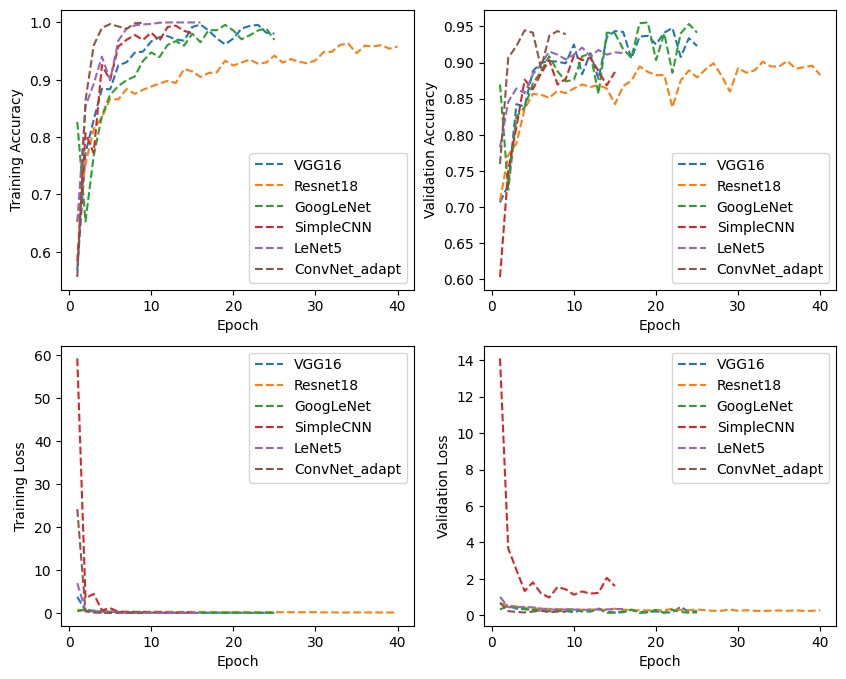

In [ ]:
name_of_model = ['VGG16','Resnet18','GoogLeNet','SimpleCNN','LeNet5','ConvNet_adapt']
model_data = {}
cmap = plt.get_cmap('tab10')
colors = [cmap(i) for i in range(6)]
for i in range(6):
  name_m = name_of_model[i]
  file_path = '/content/drive/MyDrive/Stat 7007/Loss/' + name_m+ '_loss.pkl'
  with open(file_path, 'rb') as f:
    loss_info =  pickle.load(f)
  loss_info['color'] = colors[i]
  model_data[name_m] = loss_info

model_compare(model_data)

In [ ]:
def train_plot(model_info, model_name):
  train_acc = [i[1] for i in model_info['training_acc']]
  val_acc = [i[1] for i in model_info['validation_acc']]
  train_loss = [i[1] for i in model_info['training_loss']]
  val_loss = [i[1] for i in model_info['validation_loss']]
  epochs = list(range(1, len(train_acc) + 1))

  plt.style.use('default')
  plt.figure(figsize=(5, 4))
  # Plot the training accuracy and validation accuracy
  plt.plot(epochs, train_acc, 'b', label='Train Accuracy',linestyle='-.')
  plt.plot(epochs, val_acc, 'r', label='Validation Accuracy',linestyle='-.')
  # Plot the training loss and validation loss
  plt.plot(epochs, train_loss, 'g', label='Train Loss',linestyle='--')
  plt.plot(epochs, val_loss, 'm', label='Validation Loss',linestyle='--')

  plt.title(model_name)
  plt.xlabel('Epochs')
  plt.ylabel('Metrics')
  plt.legend()

  # Adjust the spacing between subplots
  plt.tight_layout()
  plt.show()

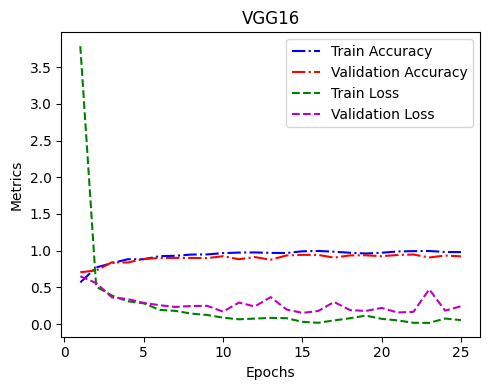

In [ ]:
train_plot(model_data["VGG16"], "VGG16")

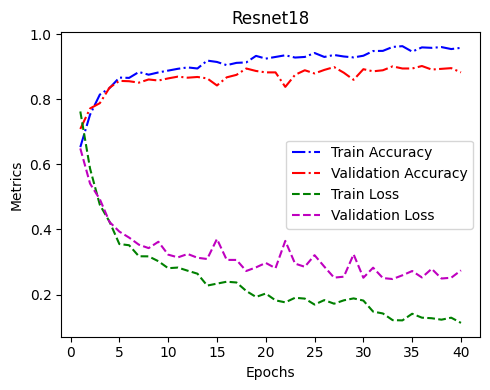

In [ ]:
train_plot(model_data["Resnet18"], "Resnet18")

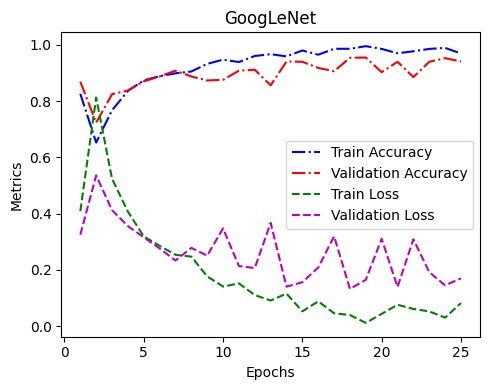

In [ ]:
train_plot(model_data["GoogLeNet"], "GoogLeNet")

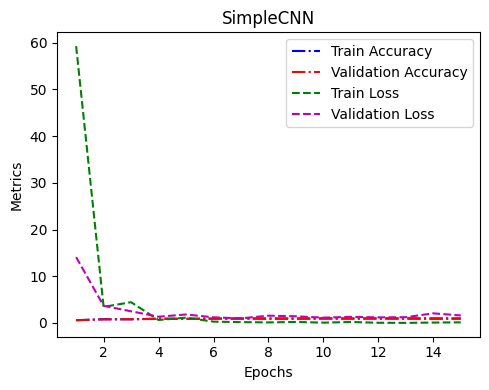

In [ ]:
train_plot(model_data["SimpleCNN"], "SimpleCNN")

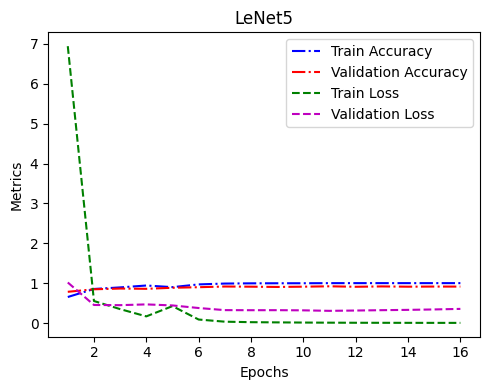

In [ ]:
train_plot(model_data["LeNet5"], "LeNet5")

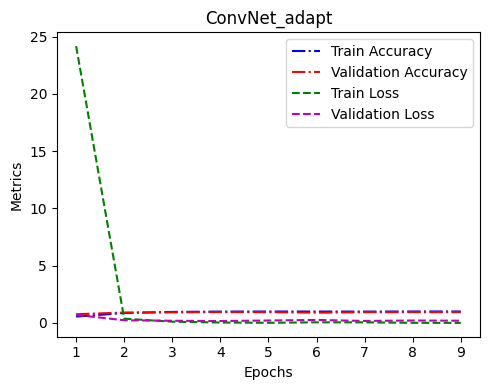

In [ ]:
train_plot(model_data["ConvNet_adapt"], "ConvNet_adapt")

## 4.2 Report and confusion matrix

In [ ]:
# Kaggle data
test_images = torch.load(path+'jpg2tensor_float32_image.pt')
test_label = torch.load(path+'jpg2tensor_float64_label.pt')

test_images = test_images.unsqueeze(1)

test_dataset = TensorDataset(test_images,test_label)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

list_test_loss = []
list_test_acc = []

classification_report
               precision    recall  f1-score   support

           0       0.91      0.88      0.89       212
           1       0.94      0.97      0.96       432
           2       0.99      0.96      0.97       276

    accuracy                           0.95       920
   macro avg       0.95      0.94      0.94       920
weighted avg       0.95      0.95      0.95       920

Accuracy of VGG16 is 0.947826.
Precision of VGG16 is 0.946122.
Recall of VGG16 is 0.937711.
F1 Score of VGG16 is 0.941673.


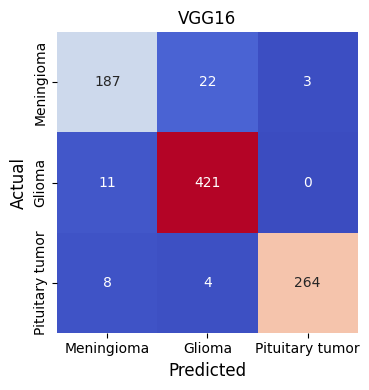

Test loss: 22.7432, Test accuracy: 0.8596


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = None
# confuse matrix for VGG16
model = vgg16
model.load_state_dict(torch.load('/content/drive/MyDrive/Stat 7007/Model/VGG16_best_weights.pt'))
model = model.to('cuda')
ppl = Pipeline(model, criterion, optimizer, model_name='VGG16' , num_epochs=25, patience= 10)
ppl.cal_confusion_metrix(val_loader)
test_loss, test_acc = ppl.test(test_loader)
list_test_loss.append(test_loss)
list_test_acc.append(test_acc)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


classification_report
               precision    recall  f1-score   support

           0       0.78      0.86      0.82       212
           1       0.95      0.89      0.92       432
           2       0.94      0.95      0.94       276

    accuracy                           0.90       920
   macro avg       0.89      0.90      0.89       920
weighted avg       0.91      0.90      0.90       920

Accuracy of Resnet18 is 0.902174.
Precision of Resnet18 is 0.888077.
Recall of Resnet18 is 0.900428.
F1 Score of Resnet18 is 0.893277.


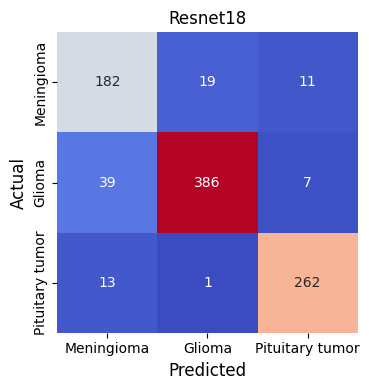

Test loss: 3.6277, Test accuracy: 0.3520


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = None
# confuse matrix for Resnet18
model = Resnet18()
model.load_state_dict(torch.load('/content/drive/MyDrive/Stat 7007/Model/Resnet18_best_weights.pt'))
model = model.to('cuda')
ppl = Pipeline(model, criterion, optimizer, model_name='Resnet18' , num_epochs=25, patience= 10)
ppl.cal_confusion_metrix(val_loader)
test_loss, test_acc = ppl.test(test_loader)
list_test_loss.append(test_loss)
list_test_acc.append(test_acc)

classification_report
               precision    recall  f1-score   support

           0       0.89      0.92      0.91       212
           1       0.97      0.96      0.96       432
           2       0.99      0.98      0.98       276

    accuracy                           0.96       920
   macro avg       0.95      0.95      0.95       920
weighted avg       0.96      0.96      0.96       920

Accuracy of GoogLeNet is 0.955435.
Precision of GoogLeNet is 0.949514.
Recall of GoogLeNet is 0.952135.
F1 Score of GoogLeNet is 0.950752.


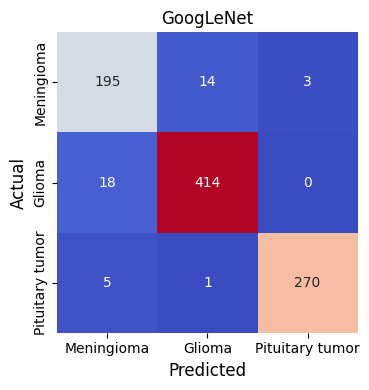

Test loss: 16.2842, Test accuracy: 0.3925


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = None
# confuse matrix for GoogLeNet
model = googlenet
model.load_state_dict(torch.load('/content/drive/MyDrive/Stat 7007/Model/GoogLeNet_best_weights.pt'))
model = model.to('cuda')
ppl = Pipeline(model, criterion, optimizer, model_name='GoogLeNet' , num_epochs=25, patience= 10)
ppl.cal_confusion_metrix(val_loader)
test_loss, test_acc = ppl.test(test_loader)
list_test_loss.append(test_loss)
list_test_acc.append(test_acc)

classification_report
               precision    recall  f1-score   support

           0       0.81      0.90      0.85       212
           1       0.96      0.89      0.92       432
           2       0.92      0.95      0.94       276

    accuracy                           0.91       920
   macro avg       0.90      0.91      0.90       920
weighted avg       0.91      0.91      0.91       920

Accuracy of SimpleCNN is 0.909783.
Precision of SimpleCNN is 0.897182.
Recall of SimpleCNN is 0.912671.
F1 Score of SimpleCNN is 0.903679.


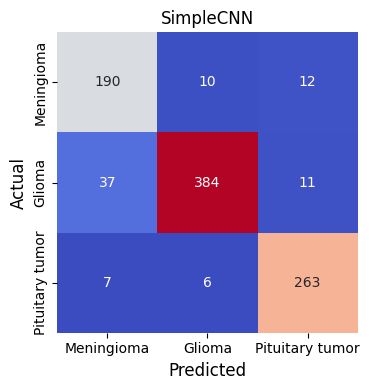

Test loss: 28.4619, Test accuracy: 0.8582


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = None
# confuse matrix for SimpleCNN
model = SimpleCNN()
model.load_state_dict(torch.load('/content/drive/MyDrive/Stat 7007/Model/SimpleCNN_best_weights.pt'))
model = model.to('cuda')
ppl = Pipeline(model, criterion, optimizer, model_name='SimpleCNN' , num_epochs=25, patience= 10)
ppl.cal_confusion_metrix(val_loader)
test_loss, test_acc = ppl.test(test_loader)
list_test_loss.append(test_loss)
list_test_acc.append(test_acc)

classification_report
               precision    recall  f1-score   support

           0       0.84      0.85      0.85       212
           1       0.94      0.92      0.93       432
           2       0.96      0.97      0.97       276

    accuracy                           0.92       920
   macro avg       0.91      0.92      0.91       920
weighted avg       0.92      0.92      0.92       920

Accuracy of LeNet5 is 0.920652.
Precision of LeNet5 is 0.911666.
Recall of LeNet5 is 0.915798.
F1 Score of LeNet5 is 0.913663.


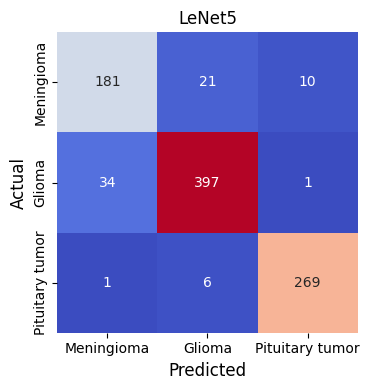

Test loss: 14.8284, Test accuracy: 0.8585


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = None
# confuse matrix for LeNet5
model = LeNet5()
model.load_state_dict(torch.load('/content/drive/MyDrive/Stat 7007/Model/LeNet5_best_weights.pt'))
model = model.to('cuda')
ppl = Pipeline(model, criterion, optimizer, model_name='LeNet5' , num_epochs=25, patience= 10)
ppl.cal_confusion_metrix(val_loader)
test_loss, test_acc = ppl.test(test_loader)
list_test_loss.append(test_loss)
list_test_acc.append(test_acc)

classification_report
               precision    recall  f1-score   support

           0       0.87      0.93      0.90       212
           1       0.96      0.94      0.95       432
           2       0.98      0.97      0.97       276

    accuracy                           0.94       920
   macro avg       0.94      0.95      0.94       920
weighted avg       0.95      0.94      0.95       920

Accuracy of ConvNet_adapt is 0.944565.
Precision of ConvNet_adapt is 0.936715.
Recall of ConvNet_adapt is 0.945148.
F1 Score of ConvNet_adapt is 0.940504.


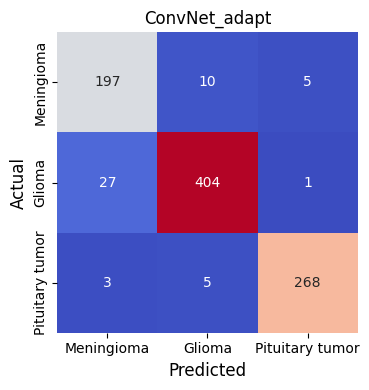

Test loss: 21.6202, Test accuracy: 0.8593


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = None
# confuse matrix for SimpleCNN
model = ConvNet_adapt()
model.load_state_dict(torch.load('/content/drive/MyDrive/Stat 7007/Model/ConvNet_adapt_best_weights.pt'))
model = model.to('cuda')
ppl = Pipeline(model, criterion, optimizer, model_name='ConvNet_adapt' , num_epochs=25, patience= 10)
ppl.cal_confusion_metrix(val_loader)
test_loss, test_acc = ppl.test(test_loader)
list_test_loss.append(test_loss)
list_test_acc.append(test_acc)

## 4.3 Indepedant test ##

In [ ]:
name_of_model = ['VGG16','Resnet18','GoogLeNet','SimpleCNN','LeNet5','ConvNet_adapt']

In [ ]:
indepedant_test = {}
indepedant_test['name of model'] = name_of_model
indepedant_test['test loss'] = list_test_loss
indepedant_test['list test acc'] = list_test_acc
print(pd.DataFrame(indepedant_test))

   name of model  test loss  list test acc
0          VGG16  22.743214       0.859624
1       Resnet18   3.627749       0.352026
2      GoogLeNet  16.284178       0.392547
3      SimpleCNN  28.461943       0.858177
4         LeNet5  14.828375       0.858538
5  ConvNet_adapt  21.620238       0.859262


<ipython-input-93-e82527febb61>:2: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(indepedant_test['test loss'][i], indepedant_test['list test acc'][i],


<function matplotlib.pyplot.show(close=None, block=None)>

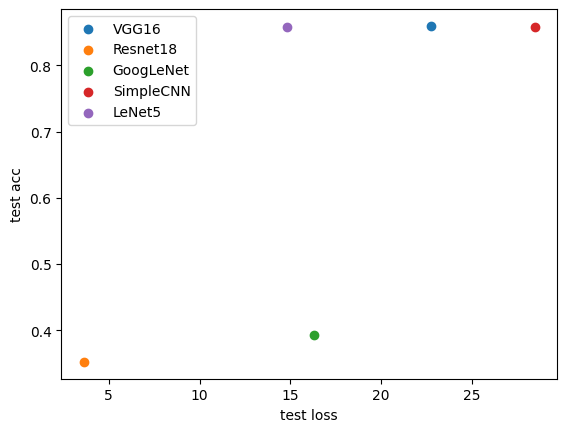

In [ ]:
for i in range(5):
  plt.scatter(indepedant_test['test loss'][i], indepedant_test['list test acc'][i],
              c = colors[i],label = indepedant_test['name of model'][i])
  plt.legend()

plt.xlabel('test loss')
plt.ylabel('test acc')
plt.show

# 5. VGG16-LR

In [ ]:
class Extractor:
    def __init__(self, model, model_name):
        self.model = model
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model_name = model_name
        self.model_path = '/content/drive/MyDrive/Stat 7007/Model/VGG_16_all_best_weights.pt'

    def extract_features(self, data_loader):
        self.model.load_state_dict(torch.load(self.model_path))
        # remove the fully connected layers of VGG16
        vgg16 = nn.Sequential(*list(self.model.features.children()))
        vgg16.eval()
        features = []
        labels = []
        with torch.no_grad():
            for data, label in data_loader:
                inputs = data.to(self.device)
                output = vgg16(inputs)
                output = output.view(output.size(0), -1)
                features.append(output)
                labels.append(label)
        features = torch.cat(features, dim=0)
        labels = torch.cat(labels, dim=0)
        return features,labels

## 5.1 Use VGG16 to extract features ##

In [ ]:
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn
from google.colab import drive

drive.mount('/content/drive')
path = '/content/drive/MyDrive/Stat 7007/Data Set/all_data_tensor/'

# load training dataset
images = torch.load(path+'mat2tensor_float32_image.pt')
label = torch.load(path+'mat2tensor_float64_label.pt')
images = images.unsqueeze(1)  # add color channel
all_dataset = TensorDataset(images,label)
all_loader = DataLoader(all_dataset, batch_size=32, shuffle=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = vgg16.to(device)
extractor = Extractor(model, model_name='VGG16')
all_features, all_labels = extractor.extract_features(all_loader)  # train_loader is all the .mat data

Mounted at /content/drive


## 5.2 Use the extracted features to train a Logistic regression Model

In [ ]:
from sklearn.linear_model import LogisticRegression
import pickle

all_features = all_features.cpu()
all_labels = all_labels.cpu()
lr = LogisticRegression()
lr.fit(all_features, all_labels)
final_path = '/content/drive/MyDrive/Stat 7007/Model/VGG16-LR.pkl'
# save VGG16-LR model
with open(final_path, 'wb') as f:
    pickle.dump(lr, f)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## 5.3 Kaggle test ##

In [ ]:
from sklearn.metrics import accuracy_score

# Kaggle data
test_images = torch.load(path+'jpg2tensor_float32_image.pt')
test_label = torch.load(path+'jpg2tensor_float64_label.pt')
test_images = test_images.unsqueeze(1)
test_dataset = TensorDataset(test_images,test_label)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
# extract testing features
test_features, test_labels = extractor.extract_features(test_loader)
test_features = test_features.cpu()
test_labels = test_labels.cpu()
preds = lr.predict(test_features)
accuracy = accuracy_score(preds,test_labels)
print("The independant test accuracy is:", accuracy)

The independant test accuracy is: 0.8809696092619392
